 **Prerequisite**
 
Since this work is using alot of pre-computed weights and initalized training data should this notebook be inside [this](https://github.com/isakhammer/deep_learning_project) git repository or a similar environment. 

If you want to test the code can you run the following block to test if you have the necessarry python libraries. All of them should be installed if you are using most recent version of Anaconda ().


In [214]:
import numpy as np
from copy import deepcopy as copy 
import matplotlib.pyplot as plt
import os
import pickle


### TMA4215 Numerical Mathematics - Project 2
# Implementation of Symplectic Recurrent Neural Network with ResNet-Architecture.


## Table of Contents 
 - ### Can be found in the bottom of the project.

**Importing Training data**


In [250]:
import numpy as np
import os
        

def import_batches():
    n_batches = 50
    
    data_prefix = "datalist_batch_"
    data_path = os.path.join( os.path.join(os.getcwd()), "project_2_trajectories")
    
    batches = {}
    
    for i in range(n_batches):
        # assemble track import path
        batch_path = os.path.join(data_path, data_prefix + str(i) + ".csv")
        batch_data = np.loadtxt(batch_path, delimiter=',', skiprows=1)
        
        # np.newaxis is adding a dimension such that (I,) -> (I, 1)
        batch = {}
        batch["t"] = batch_data[:, 0, np.newaxis]
        batch["Y_q"] = batch_data[:, 1:4].T
        batch["Y_p"] = batch_data[:, 4:7].T
        batch["c_p"] = batch_data[:, 7, np.newaxis] 
        batch["c_q"] = batch_data[:, 8, np.newaxis] # potential energy
        
        batches[i] = batch

    return batches

def import_one_batch():
   
    data_prefix = "datalist_batch_"
    data_path = os.path.join(os.path.dirname(__file__), "project_2_trajectories")
    
    batches = {}
    
    i = 0
    # assemble track import path
    batch_path = os.path.join(data_path, data_prefix + str(i) + ".csv")
    batch_data = np.loadtxt(batch_path, delimiter=',', skiprows=1)
        
    # np.newaxis is adding a dimension such that (I,) -> (I, 1)
    batch = {}
    #batch["t"] = batch_data[:, 0, np.newaxis]
    batch["Y_q"] = batch_data[:, 1:4].T
    batch["Y_p"] = batch_data[:, 4:7].T
    batch["c_p"] = batch_data[:, 7, np.newaxis] 
    batch["c_q"] = batch_data[:, 8, np.newaxis] # potential energy
        
    batches[0] = batch

    return batch



## 1.
### Implement functions for generating synthetic input data.

The proposed functions we choose as synthetic input this functions.

$$
f_1(y) = \frac{1}{2}y_1^2 + \frac{1}{2}y_2^2
$$

$$
f_2(y) = \frac{1}{2}{y}^2 
$$

$$
f_3(y) = 1 - cos(y)
$$

$$
f_4(y) = -\frac{1}{\|{y}\|}
$$


In [216]:
def f_1(y):
    return 0.5*y[0]**2 + 0.5*y[1]**2 

def f_2(y):
    return 0.5* np.square(y)

def f_3(y):
    return 1 - np.cos(y)

def f_4(y):
    return -1/np.sqrt(y[0]**2 +  y[1]**2 )


def generate_synthetic_batches(I,func = "2sqr", low=None, high=None):
    
    batch = {} 
    
    if func == "2sqr":
        
        d_0 = 2
        if (high==None) and (low==None):
            high=2
            low=-2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )    
        batch["c"] = f_1(batch["Y"])
        batch["c"] = batch["c"][:, np.newaxis]
        
        ct = f_1(batch["Y"] ) 
        return batch
    
    elif func == "1sqr":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=2
            low=-2
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_2(batch["Y"] )
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "1cos":
        d_0 = 1
        
        if (high==None) and (low==None):
            high=np.pi/3
            low=-np.pi/3
        
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I) )
        batch["c"] = f_3(batch["Y"] )
        batch["c"] = batch["c"].T
        return batch
    
    elif func == "2norm-1":
        if (high==None) and (low==None):
            high=2
            low=-2
            
        d_0 = 2
        batch["Y"] = np.random.uniform(high, low, size=(d_0,I))
        
        for y in batch["Y"].T:
            if (np.all(y == 0)):
                y = np.array([0.1,0.1])
        
        batch["c"] = f_4(batch["Y"]) 
        batch["c"] = batch["c"].T
        batch["c"] = batch["c"][:, np.newaxis]
            
        return batch
        
    
    else:
        raise Exception("Not axeped func")
        
        


## 2. 
### Implement the neural network for training approximation of Hamiltonian function

The proposed model is formulated as 
$$
\tilde{F}(Y; \theta) = \eta((Z^{(K)})^T w + \mu \mathbf{1} ) 
$$
where for $k = 0, 1, 2, ... , K-1 $
$$
Z^{(k+1)} = Z^{(k)} + h  \sigma(W_k Z^{(k)} + b_1 ), \\
Z^{(0)} = \hat{I} Y.
$$
Here is a

$$
\hat{I} = 
\begin{bmatrix}
I_{d_0 \times d_0} \\
\textbf{0} 
\end{bmatrix}
$$



where the gradient is define as 
...





In [217]:
def F_tilde(Y, th, d_0, d, K, h):
    
    Z = {}
    I_d = np.identity(d)[:,:d_0]
    Z[0] = I_d@Y

    for k in range(K):
        Z_hat = th["W"][k]@Z[k]+th["b"][k]
        Z[k+1] = Z[k] + h*sigma(Z_hat, False)
    
    Upsilon = eta(Z[K].T@th["w"]+th["mu"])
    
    return Z, Upsilon 


def initialize_weights(d_0, d, K):
    th = {}
    
    th["W"] = np.zeros((K, d, d))
    th["b"] = np.zeros((K, d, 1))
    
    for i in range(K):
        th["W"][i] = np.identity(d)
        th["b"][i] = np.zeros((d, 1))
            
    th["w"] = np.ones((d, 1 ))
    th["mu"] = np.zeros((1, 1))
    
    return th



def sigma(x, derivative=False):   
    if (derivative):
        return 1 / np.cosh(x)**2 
    return np.tanh(x)

def eta(x, derivative=False, identity=False):
    if identity==True:
        if (derivative):
            return np.ones(x.shape)
        return x
    else:
        if (derivative):
            return 0.25*(np.cosh(0.5*x) )**(-2)
        return 0.5*np.tanh(0.5*x) + 0.5




The objective function is on the form 

$$
J(\theta) = \frac{1}{2} \lVert  \tilde{F} (Y; \theta) - c \rVert ^{2}
$$
where $\theta  = \{ W_0, ..., W_{K-1}, b_0, ..., b_{K-1} , w, \mu\}$.

However, to be able to optimize the parameters $\theta$ can the gradient of $\nabla J(\theta)$ be formulated for the last layer like this

$$
\begin{align}
\frac{\partial J}{\partial \mu} &= \eta '((Z^{(K)})^T w + \mu \mathbf{1} )^T (\Upsilon -c) \\
\frac{\partial J}{\partial w} &= Z^{(K)} \left [ (\Upsilon - c) \odot \eta'((Z^{(K)})^T w + \mu  \right ]
\end{align}
$$
and similarly for the hidden layers,
$$
\begin{align}
P^{(K)} &= w \cdot \left [ (\Upsilon - c) \odot \eta'\left (  (Z^{(K)})^T w + \mu \mathbf{1}\ \right) \right ]^T  \\ 
P^{(k-1)} &= P^{(k)} + h W_{k-1}^{T} \cdot \left [ \sigma'\left (  W_{k-1} Z^{(k-1)} + \beta_{k-1} \ \right) \odot P^{(k)} \right ]  \\
\frac{\partial J}{\partial W_k} &= h \left [ P^{(k+1)} \odot \sigma ' (W_k Z^{(k)}  + b_k) \right ] (Z^{(k)})^T \\
\frac{\partial J}{\partial b_k} &= h \left [ P^{(k+1)} \odot \sigma ' (W_k Z^{(k)} + b_k) \right ] \mathbf{1}.
\end{align}
$$







In [218]:
def J_func(Upsilon, c):
    return 0.5*np.linalg.norm(c - Upsilon)**2


def dJ_func(c, Y, th, d_0, d, K, h):
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    I = Upsilon.shape[0]
        
    etahat = eta(Z[K].T@th["w"] + th["mu"]*np.ones(( I, 1)), derivative=True )
        
    P = np.zeros(( K+1, d, I))
    
    P[K] = np.outer(th["w"], ( (Upsilon - c)* etahat).T)
        
    dJ_mu = etahat.T @(Upsilon - c)
        
    dJ_w = Z[K] @ ((Upsilon - c) * etahat)
        
    for k in range(K, 0, -1):
        P[k-1] = P[k] + h*th["W"][k-1].T @ (sigma(th["W"][k-1]@Z[k-1]+np.outer(th["b"][k-1],np.ones(I)), True) * P[k])
            
    dJ_W = np.zeros((K, d, d))
    dJ_b = np.zeros((K, d, 1))
        
    for k in range(K):
        dsigma = sigma(th["W"][k]@Z[k]+np.outer(th["b"][k],np.ones(I)),True)
            
        dJ_W[k] = h*(P[k+1]*dsigma) @ Z[k].T
        dJ_b[k] = (h*(P[k+1]*dsigma) @ np.ones(I))[:,np.newaxis]
    dJ = {}
    dJ["w"], dJ["mu"], dJ["W"], dJ["b"] = dJ_w, dJ_mu, dJ_W, dJ_b
    return dJ

To make sure our training data is inside the range of the hypothesis function $\eta$ we use a  linear scaling funtion to scale the data. The scaling function is given by:
$$
\hat{x} = \frac{(b - x) \alpha + (x - a)\beta }{b - a}
$$

and the inverse function

$$
x = \frac{(\hat{x}+ \alpha ) b - (\hat{x} - \beta)a}{ \beta -  \alpha}
$$

where $b = \max _{i,j} x$ and $a = \min _{i,j} x$ such that all values in $ [a,b ] \mapsto [\alpha, \beta]$. Since the range of our $\eta$ is $[0,1]$  we choose $\beta = 1$ and $\alpha = 0$. Later in the project will we also have use for inverted scaling without shift, this is in the context of finding the derivative. 
$$
x = \frac{\hat{x} (b-a) }{\beta - \alpha }
$$



In [219]:

def scale(x, alpha=0, beta=1, returnParameters = False):
    
    a = np.min(x)
    b = np.max(x)
    
    if returnParameters:        
        return alpha, beta, a, b

    else:
        def  invscale(x):
            return ((x + alpha)*b - (x - beta)*a) / (beta-alpha)
        
        return ( (b - x)*alpha + (x - a)*beta)/(b - a), invscale
     
def invscaleparameter(x, alpha, beta, a, b):
    return ((x+alpha)*b - (x-beta)*a) / (beta-alpha)

def invscaleparameter_no_shift(x, alpha, beta, a, b):
    return x*(b-a)/(beta-alpha)

**Optimization Algorithms**

We will evaluate two optimization algorithms in the project. 

**Gradient Descent Algorithm**
$$
\theta_{i+1} = \theta_{i+1} - \tau \nabla J(\theta^{(r)})
$$
**Adams Algorithm**

```
beta_1, beta_2 = 0.9, 0.999
alpha = 0.01
epsilon = 10^(-8)

v_0, m_0 = 0, 0

while not converged:
    g = dJ(th)
    m = beta_1 m + ( 1- beta_1)g_j
    v = beta_2 v + (1 - beta_2)(g*g)
    m_hat = m/(1 - beta_1^j)
    v_hat = v/(1 - beta_2^j)
    theta = theta - alpha m_hat/ ( v_hat^(0.5) + epsilon )
    
```





In [220]:

def gradientDesent(K, th, dJ, tau):
    
    th["mu"] = th["mu"] - tau*dJ["mu"]
    th["w"] = th["w"] - tau*dJ["w"]
    
    th["W"] = th["W"] -  tau*dJ["W"]
    th["b"] = th["b"] -  tau*dJ["b"]
    return th


def adam_algebra(th, dJ, v, m, key, j, alpha =10**(-5)):
        beta_1, beta_2 =  0.9, 0.999
        epsilon =  10**(-8)
    
        g = dJ[key] 
        m[key] = beta_1*m[key] + (1- beta_1)*g
        v[key] = beta_2*v[key] + (1 - beta_2)*(g*g)
        mhat = m[key]/(1 - beta_1**(j+1))
        vhat = v[key]/(1 - beta_2**(j+1))
        th[key] -= alpha*mhat/(np.square(vhat) + epsilon)
        return th, v, m
    


**Training Procedure**

In [221]:



def train(c, d, d_0, K, h, Y, th, tau=0.0005, max_it=60, print_it=True, method="gd", alpha =7.5*10**(-5)):
    # compute Zk
    err = np.inf
    tol = 0.01
    
    
    itr = 0
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    JJ = np.zeros(max_it+1)
    err = J_func(Upsilon,c)
    
    JJ[0] = err
    
    # Adam parameters 
    m = {}
    m["mu"] = np.zeros(th["mu"].shape)
    m["w"] = np.zeros(th["w"].shape)
    m["W"] = np.zeros(th["W"].shape)
    m["b"] = np.zeros(th["b"].shape)
    v = copy(m)
    
    
    while (itr < max_it ):
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        
        if (method=="gd"):
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            th = gradientDesent(K, th, dJ, tau)
        
        elif (method=="adam"):
            j = itr
            
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            
            th, v, m = adam_algebra(th, dJ, v, m, "mu", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "w", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "W", j, alpha)
            th, v, m = adam_algebra(th, dJ, v, m, "b", j, alpha)
            
        else:
            print("No optimization method")
        
        err = J_func(Upsilon, c)  
        
        JJ[itr+1] = err
        
        itr += 1
        
        if(itr%600 == 0) and (print_it == True):
            print(itr,err)
        
    return JJ , th
        
def stocgradient(c, d, d_0, K, h, Y, th, tau, max_it , bsize, sifts = 100, save = False, savefile = ""):
    
    JJ = np.zeros(sifts)
    I = Y.shape[1]
    totitr = int(I/bsize)
    for siftnum in range(sifts):
        print(siftnum)
        
        indexes = np.array(range(I))
        
        np.random.shuffle(indexes)
        
        itr = 0
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        err = J_func(Upsilon, c)
        JJ[siftnum] = err
        
        if save and siftnum%100 == 0:
            th_file = open(savefile, "wb")
            pickle.dump(th, th_file)
            th_file.close()
        
        while len(indexes) > 0:
         
            if len(indexes) >= bsize:
                bsliceI = indexes[:bsize]
                Yslice = Y[:,bsliceI]
                cslice = c[bsliceI]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                
                indexes = indexes[bsize:]
                
            else:
                Yslice = Y[:,indexes]
                cslice = c[indexes]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                
                indexes = []
            
    return JJ, th





**Stochastic Gradient**

Since the objective function is independent of time can it be training with unordered trainingdata. Using this fact can we sweep through the dataset faster by random shuffling and slizing the entire dataset.  We will in the implementation assume that the dataset is already merged for $c$ and $Y$, and will allocate the job to the data pre-processing. 


In [222]:
def stocgradient(c, d, d_0, K, h, Y, th, tau, max_it , bsize, sifts = 100):
    
    JJ = np.array([])
    I = Y.shape[1]
    totitr = int(I/bsize)
    for siftnum in range(sifts):
        
        indexes = np.array(range(I))
        np.random.shuffle(indexes)
        
        itr = 0
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        err = J_func(Upsilon, c)
        JJ = np.append(JJ, err)
        
        while len(indexes) > 0:
            
            if len(indexes) >= bsize:
                bsliceI = indexes[:bsize]
                Yslice = Y[:,bsliceI]
                cslice = c[bsliceI]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it)
                indexes = indexes[bsize:]
             
            else:
                Yslice = Y[:,indexes]
                cslice = c[indexes]
                
                dJJ, th = train(cslice, d, d_0, K, h, Yslice, th, tau, max_it) 
                indexes = []
            
    return JJ, th


 ## 2. a) 
 ### Test the model by using the suggested functions

In [223]:
def train_func(func):
    
    I = 8000
    K = 20
    h = 0.1
    sifts = 400
    Ihat = 320
    tau = 3/Ihat  
    
    data = generate_synthetic_batches(I, func)
    
    Y =data["Y"]
    c = data["c"]
    sc , invc = scale(c)
    sparameters = scale(c,returnParameters = True)
    
    inv_file = open( func+"_inv.pkl", "wb")
    pickle.dump(sparameters, inv_file)
    inv_file.close()
    
    d_0 = Y.shape[0]
    d = d_0*2
    
    th = initialize_weights(d_0, d, K)
    
    JJ, th = stocgradient(sc, d, d_0, K, h, Y, th, tau, 1 , Ihat, sifts)
    
    plt.plot(JJ)
    plt.yscale("log")
    plt.title("Cost Function for " + func)
    plt.show()
    
    th_file = open(func + "_th.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()
    
    
    
def test_func(func):
    
    numData = 2000
    
    K = 20
    h = 0.1
    
    
    if func == "1sqr":
        Y  = np.linspace(-2,2,numData)
        Y = Y[:,np.newaxis].T
        c = 1/2*Y**2
        c = c.T
        
    elif func == "1cos":
        Y = np.linspace(-np.pi/3,np.pi/3,numData)
        Y = Y[:,np.newaxis].T
        c = 1-np.cos(Y)
        c = c.T
        
    elif func == "2sqr":
        x1 = np.linspace(-2,2,numData)
        Y = np.array([x1,-x1])
        c = 1/2*(Y[0]**2 + Y[1]**2)
        c = c.T
        
    elif func == "2norm-1":
        x2hat1 = np.linspace(-2,-1/4,int(numData/2))
        x2hat2 = np.linspace(1/4,2,int(numData/2))
        x2 = np.append(x2hat1,x2hat2)
        Y = np.array([x2,-x2])
        c = -1/np.sqrt(Y[0]**2 + Y[1]**2)
        c = c.T
        
    else:
        raise Exception("No func")
        
    
    d_0 = Y.shape[0]
    d = d_0*2
    
    
    inv_file = open( func+"_inv.pkl", "rb")
    inv = pickle.load(inv_file)
    inv_file.close()
    
    th_file = open(func + "_th.pkl", "rb")
    th = pickle.load(th_file)
    th_file.close()
    z, yhat = F_tilde(Y, th, d_0, d, K, h)
    
    y = invscaleparameter(yhat, inv[0], inv[1], inv[2], inv[3])
    if d_0 == 1:
        plt.plot(Y.T, y, label ="Estimated function")
        plt.plot(Y.T,c, label ="Analytical function")
        plt.title("Comparison for " + func)
        plt.legend()
        plt.show()
    else:
        plt.plot(y, label ="Estimated function")
        plt.plot(c, label ="Analytical function")
        plt.title("Comparison for " + func)
        plt.legend()
        plt.show()

In [224]:
print("Train model for 1sqr Function")
#train_func(func="1sqr")
print("Train model for cos Function")
#train_func(func="1cos")

Train model for 1sqr Function
Train model for cos Function


In [225]:
print("Train model for 2sqr Function")
#train_func(func="2sqr")

Train model for 2sqr Function


In [226]:
print("Train model for 2norm-1 Function")
#train_func(func="2norm-1")

Train model for 2norm-1 Function


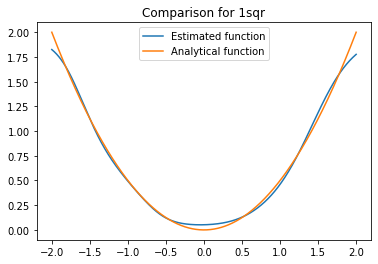

In [227]:
test_func(func="1sqr")

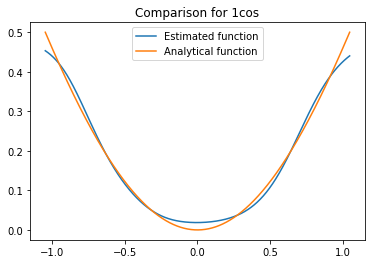

In [228]:
test_func(func="1cos")

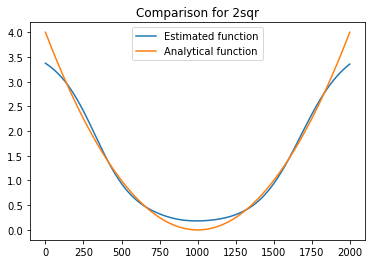

In [229]:
test_func(func="2sqr")

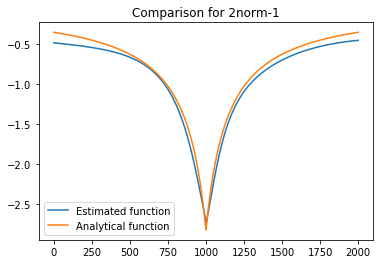

In [230]:
test_func(func="2norm-1")

## 2. b)
### Investigate systematically what are optimal choices for K, τ , d, h and any other choices you need to make. Balance performance in the generalisation phase with time consumption of training

**Tau Sensitivity**


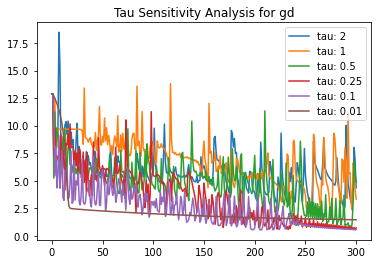

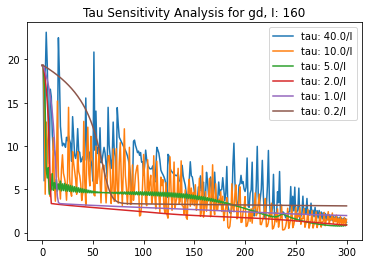

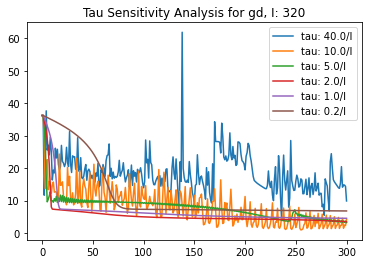

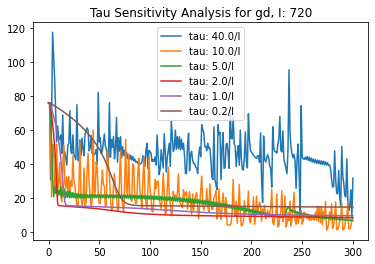

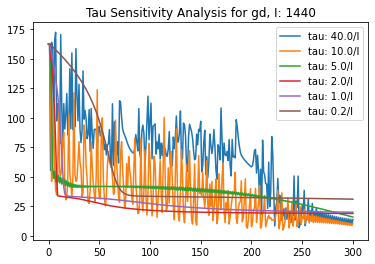

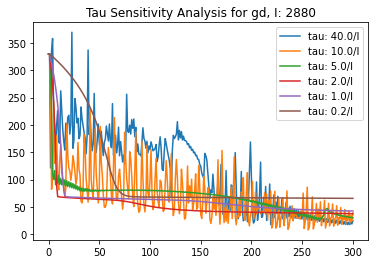

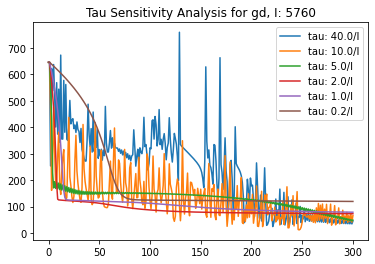

In [47]:


# Chosen default values
K = 20
h = 0.1
d_0 = 2
d = 4
I = 600
max_it = 300
tauxI = 2


def tau_sensitivity(method="gd"):
           
    I = 100     
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = [ 2, 1, 0.5, 0.25, 0.1, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="tau: "+ str(tau))
    
    plt.title("Tau Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
    
def tauI_sensitivity(I, method="gd"):            
    
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = np.array([ 40, 10, 5, 2, 1, 0.2])/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method)
        plt.plot(it, JJ, label="tau: "+ str(tau*I) + "/I")
    
    plt.title("Tau Sensitivity Analysis for " + method + ", I: "+str(I))
    plt.legend()
    plt.show()

tau_sensitivity(method="gd")
I = [160, 320, 720, 1440, 2880, 5760]
for i in I:
    tauI_sensitivity(i)

We discover that the rate and stability of the convergence of the gradient desent method for a given $\tau$ is dependent on the number of data points $I$. We also discover that by using a $\tau$ that is inversely proportional with $I$, the convergence is similar for different choices of $I$. By looking at the analisys we find that $\tau = 2/I$ has the best rate and stability.

**Alpha Sensitivity**

<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2


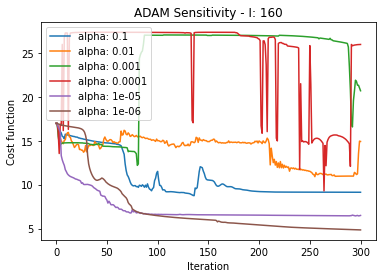

<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:45: RuntimeWarning: overflow encountered in cosh
  return 0.25*(np.cosh(0.5*x) )**(-2)
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:45: RuntimeWarning: overflow encountered in cosh
  return 0.25*(np.cosh(0.5*x) )**(-2)
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**

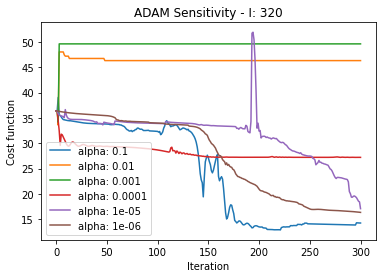

<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in cosh
  return 1 / np.cosh(x)**2
<ipython-input-33-5ce5054187a9>:35: RuntimeWarning: overflow encountered in square
  return 1 / np.cosh(x)**2


In [ ]:

def alpha_sensitivity(method="adam"):
                
    I = 100
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = [0.75*10**-4, 0.5*10**-4, 0.35*10**-4, 0.75*10**-5, 0.5*10**-5, 0.25*10**-6]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        alpha = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method, alpha=alpha)
        plt.plot(it, JJ, label="alpha: "+ str(alpha))
    
    plt.title("Alpha Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
    
def alphaI_sensitivity(I, method="adam"):            
    
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = np.array( [10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6 ])#/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        alpha = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method=method, alpha=alpha)
        plt.plot(it, JJ, label="alpha: "+ str(alpha) )
    
    plt.title("ADAM Sensitivity - " + "I: "+str(I))
    plt.xlabel("Iteration")
    plt.ylabel("Cost function")
    plt.legend()
    plt.show()



    
I = [160, 320, 720, 1440, 2880, 5760]
for i in I:
    alphaI_sensitivity(i)

        

**h Sensitivity**

In [ ]:

def h_sensitivity(method="gd"):
    I = 300
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = var = [ 0.14, 0.12, 0.1, 0.07, 0.05, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        h = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tauxI/I, max_it=max_it, method=method)
        plt.plot(it, JJ, label="h: "+ str(var[i]))
    
    plt.title("h Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()

h_sensitivity(method="gd")

$h = 0.1$ seems to be a good choice.

**I-sensitivity**

I: 15
I: 20
I: 40
I: 80
I: 160
I: 320
I: 640
I: 1280


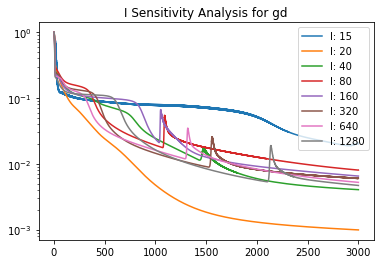

In [50]:

def I_sensitivity(method="gd"):
    max_it = 3000             
    var = var = [ 15, 20, 40, 80, 160, 320, 640, 1280]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        I = var[i]
        b = generate_synthetic_batches(I)
        c, inv = scale(b["c"])
        Y = b["Y"]
        d_0 = Y.shape[0]
    
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tauxI/I, max_it=max_it, print_it=False, method=method)
        JJ = JJ/JJ[0]
        plt.plot(it, JJ, label="I: "+ str(var[i]))
    
    plt.title("I Sensitivity Analysis for " + method)
    plt.yscale("log")
    plt.legend()
    plt.show()
I_sensitivity(method="gd")

**d-sensitivity**

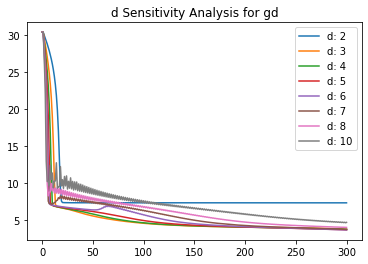

In [51]:


def d_sensitivity(method="gd"):
    I = 300         
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = var = [ 2, 3, 4, 5, 6, 7, 8, 10 ]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        d = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tauxI/I, max_it=max_it, method=method)
        plt.plot(it, JJ, label="d: "+ str(var[i]))
    
    plt.title("d Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
d_sensitivity(method="gd")

$d = 4$ seems to be a good choice.

**K-Sensitivity**

600 21.668749520659812
1200 13.228532410521483
600 15.108033053861362
1200 12.335469659320097
600 12.575108736870526
1200 1.6078842665092516
600 9.275651928175229
1200 1.0884809842793213
600 5.015019647696936
1200 1.071828076187067
600 4.111772410106386
1200 1.1140155353772219
600 13.847856467092521
1200 2.2303491330435374


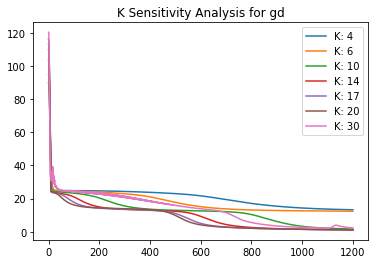

In [52]:

def K_sensitivity(method="gd"):
    I = 1000         
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    d_0 = Y.shape[0]
    
    var = var = [ 4, 6, 10, 14, 17, 20, 30]
    it = np.arange(0,max_it*4+1)
    
    for i in range(len(var)):    
        K = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tauxI/I, max_it=max_it*4, method=method)
        plt.plot(it, JJ, label="K: "+ str(var[i]))
    
    plt.title("K Sensitivity Analysis for " + method)
    plt.legend()
    plt.show()
K_sensitivity(method="gd")

$K = 20$ seems to be a good choice.

## 2. c)
### Train the model for the case of data given (with unknown Hamiltonian function).

In [70]:
 
def train_uknown() :
    K = 20
    h = 0.1
    I = 80
    max_it = 1
    sifts = 110
    tau = 0.1
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 40
    testbatch = batches[antB-1]
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    th = initialize_weights(d_0, d, K)
    JJ = np.array([])

    bigbatch = {}
    bigbatch["Y"] = np.array([[],[],[]])
    bigbatch["c"] = np.array([])
    
    for i in range(antB):
        batch = batches[i]
        bigbatch["Y"] = np.append(bigbatch["Y"],batch["Y_q"],1)
        bigbatch["c"] = np.append(bigbatch["c"],batch["c_q"])
        
    Y = bigbatch["Y"]
    c,inv = scale(bigbatch["c"][:,np.newaxis])
    
    JJ, th = stocgradient(c, d, d_0, K, h, Y, th, tau, 1 , 40, sifts)
 
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    tY = testbatch["Y_q"]
    tc,invscale = scale(testbatch["c_q"])
    
    z, yhat = F_tilde(tY, th, d_0, d, K, h)
    
    y = invscale(yhat)
    ic = invscale(tc)
    
    plt.plot(y)
    plt.plot(ic)
    plt.show()
    
    th_file = open("weights.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()

# COMMENT OUT TO TRAIN ON UKNOWN DATA
#train_uknown()

##  2. d) 
### Try other alternatives for optimisation, such a the Adam method



In [232]:
## ADAM CODE

## 



##  2. e) 
### Make use of convergence plots for getting an indication of the efficiency of your choices



In [233]:
def test_unknown(pq, low = 0, high = 1):
    
    K = 20
    h = 0.1
    
    
    inv_file = open( pq + "_unknown_inv.pkl", "rb")
    inv = pickle.load(inv_file)
    inv_file.close()
    
    w_file = open(pq + "_unknown_w.pkl", "rb")
    th = pickle.load(w_file)
    w_file.close()
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 50
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    b_indexes = np.arange(low,high+1)
    
    #for i in range(antB):
    for i in b_indexes:
        plt.title("Batch: " + str(i) + ",   y = F(" + pq +")")
        testbatch = batches[i]
    
        tY = testbatch["Y_"+pq]
        
        z, yhat = F_tilde(tY, th, d_0, d, K, h)
        
        
        y = invscaleparameter(yhat, inv[0], inv[1], inv[2], inv[3])
        c = testbatch["c_"+pq]
        
        
        print("Mean error:", np.average(np.abs(y-c)))
        
        plt.plot(y,label ="y")
        plt.plot(c,label ="c")
        plt.ylim(-0.2,0.8)
        plt.legend()
        plt.show()

Mean error: 0.0035752891941011455


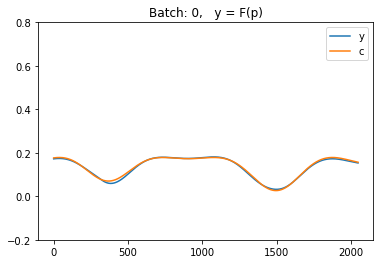

Mean error: 0.003605999106927585


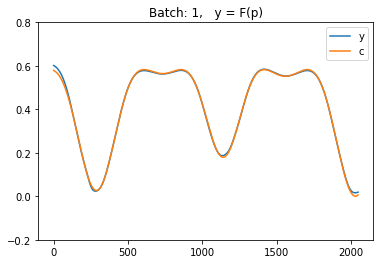

Mean error: 0.010534481038605248


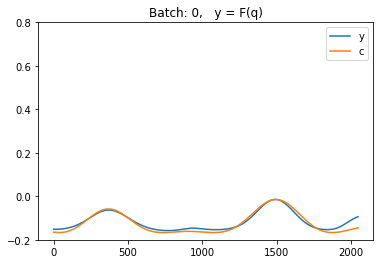

Mean error: 0.009004505360867445


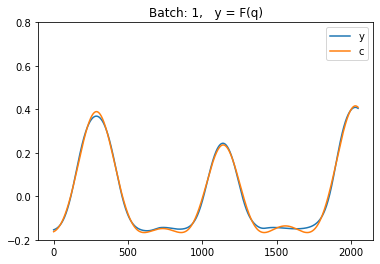

Mean error: 0.0024917391517664954


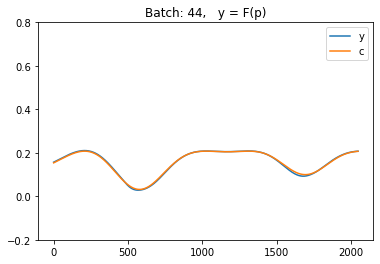

Mean error: 0.003488720078072171


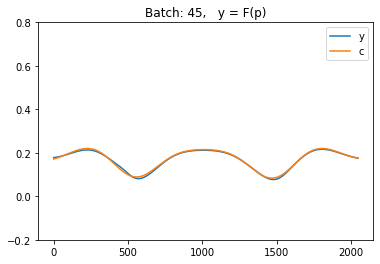

Mean error: 0.007688026495715197


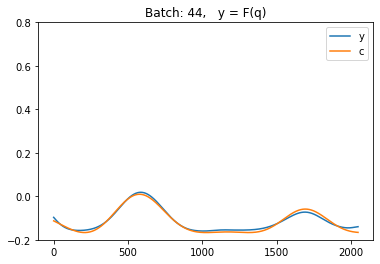

Mean error: 0.0050932947488626056


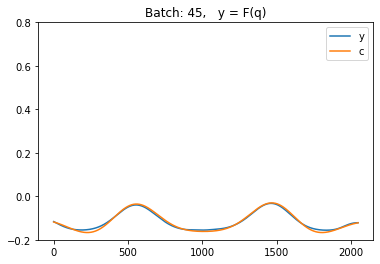

In [234]:
test_unknown("p",0,1)
test_unknown("q",0,1)
test_unknown("p",44,45)
test_unknown("q",44,45)

Here y is the numerical values and c is the analytical values. We see that the numerical vaues aproximates the analytical ones quite closely. The training data was batches 0 to 39, we the that the trained function generalizes nicely to the test data (batches 40 to 49) that was not included in the training data.

## 3.
Derive the formulas for computing the gradient of the trained function $$(\nabla_y\tilde{F}(y))$$

Let 
$$
A_{K} = \nabla G(Z^K) = \eta'( w^T Z^{(K)} + \mu) w
$$

for  $k$ in range $(K,0,-1)$:
$$
\begin{split}
A_{k-1}  &= (D \Phi_{k-1} (Z^{k-1})  )^T A_{k} \\
   &= A_{k} + W_{k-1}^T( h \sigma ' (W_{k-1} Z^{(k-1)} + b_k) \circ A_{k})
\end{split}
$$
We can define the result as
$$
\nabla \tilde{F} =  A_K
$$

## 4.
### Implement these formulas for computing the gradient

In [235]:

def dF_tilde_y2(y, h, th, d_0, d, K):
    
    Z, Upsilon = F_tilde(y, th, d_0, d, K, h)
    
    dGZK = eta(th["w"].T@Z[K]+ th["mu"], derivative = True) * th["w"]
    
    A = dGZK
    for k in range(K,0,-1):
        A = A + th["W"][k-1].T@(h*sigma((th["W"][k-1]@Z[k-1] + th["b"][k-1]), derivative = True)*A)
    
    return A[:d_0]


In [236]:
def test_grad_1sqr():
    
    func = "1sqr"
    
    numData = 2000
    K = 20
    h = 0.1
    
    
    Y  = np.linspace(-2,2,numData)
    Y = Y[:,np.newaxis].T
    c = Y
    c = c.T
    
    d_0 = Y.shape[0]
    d = d_0*2
    
    
    inv_file = open( func+"_inv.pkl", "rb")
    inv = pickle.load(inv_file)
    inv_file.close()
    
    th_file = open(func + "_th.pkl", "rb")
    th = pickle.load(th_file)
    th_file.close()
    
    yhat = dF_tilde_y2(Y, h, th, d_0, d, K)
    
    y = invscaleparameter_no_shift(yhat, inv[0], inv[1], inv[2], inv[3])
    
    plt.plot(Y.T, y.T, label ="Estimated gradient")
    plt.plot(Y.T, c, label ="Analytical gradient")
    plt.title("Comparison of gradient for F(y) = 1/2 y^2")
    plt.legend()
    plt.show()

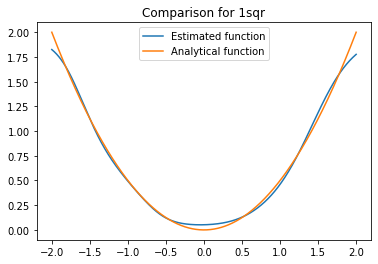

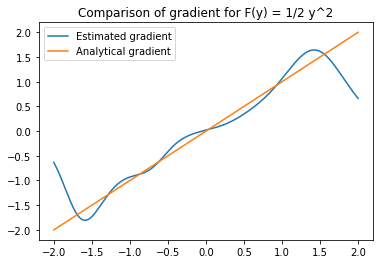

In [237]:
test_func(func="1sqr")
test_grad_1sqr()

As we can see the impementation does a good job of calulating the gradient of the numerical function. We see that the numerical function diverges away from the analytical one. So it makes sence for the numerical gradient to also diverge from the numerical one.

## 5.
### Implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian

Symplectic Euler is formulated as
$$
\begin{align}
q_{n+1} &= q_n + \Delta t \frac{\partial T}{\partial p} (p_{n}) \\
p_{n+1} &= p_n - \Delta t\frac{\partial V}{\partial q} (q_n) \\
\end{align}
$$

In [238]:
def s_euler(p0, q0, thp, thq, hF, K, N, T, invp, invq):
    
    h = T/N
    
    d_0 = p0.shape[0]
    d = d_0*2
    
    p = np.zeros((N+1,1,1))
    p[0] = p0
    
    q = np.zeros((N+1,1,1))
    q[0] = q0
    
    for n in range(N):
        
        dTs = dF_tilde_y2(p[n], hF, thp, d_0, d, K)
        dT = invscaleparameter_no_shift(dTs, invp[0], invp[1], invp[2], invp[3])
        dVs = dF_tilde_y2(q[n], hF, thq, d_0, d, K)
        dV = invscaleparameter_no_shift(dVs, invq[0], invq[1], invq[2], invq[3])
        
        q[n+1] = q[n] + h*dT[:d_0]
        p[n+1] = p[n] - h*dV[:d_0]
    
    p = np.reshape(p,N+1)
    q = np.reshape(q,N+1)
    return p,q

Størmer-Verlet is formulated as 
$$
\begin{align}
p_{n+1/2} &= p_n - \frac{\Delta t}{2} \frac{\partial V}{\partial q} (q_n) \\
q_{n+1} &= q_n + \Delta t \frac{\partial T}{\partial p} (p_{n + 1/2}) \\
p_{n+1} &= p_{n + 1/2} - \frac{\Delta t}{2} \frac{\partial V}{\partial q} (q_{n+1})
\end{align}
$$

In [239]:
def stormer_verlet(p0, q0, thp, thq, hF, K, N, T, invp, invq):
    
    h = T/N
    
    d_0 = p0.shape[0]
    d = d_0*2
    
    p = np.zeros((N+1,d_0,1))
    p[0] = p0
    
    q = np.zeros((N+1,d_0,1))
    q[0] = q0
    
    for n in range(N):
        
        dVs = dF_tilde_y2(q[n], hF, thq, d_0, d, K)
        dV = invscaleparameter_no_shift(dVs, invq[0], invq[1], invq[2], invq[3])
        p_hat = p[n] - (h/2)*dV
        
        dTs = dF_tilde_y2(p_hat, hF, thp, d_0, d, K)
        dT = invscaleparameter_no_shift(dTs, invp[0], invp[1], invp[2], invp[3])
        q[n+1] = q[n] + h*dT        
        
        dVs = dF_tilde_y2( q[n+1], hF, thq, d_0, d, K)
        dV1 = invscaleparameter_no_shift(dVs, invq[0], invq[1], invq[2], invq[3])
        p[n+1] = p_hat - (h/2)*dV1
        
        
    p = np.reshape(p,(N+1,d_0))
    q = np.reshape(q,(N+1,d_0))
    return p,q


def stormer_verlet_analytical(p0, q0, N, T,  dT, dV):
    
    h = T/N

    d_0 = p0.shape[0]
    d = d_0*2
    
    p = np.zeros((N+1,d_0,1))
    p[0] = p0
    
    q = np.zeros((N+1,d_0,1))
    q[0] = q0
    
    for n in range(N):
        # 1
        dVq = dV(q[n])
        phat = p[n] - h/2*dVq
        dTph = dT(phat)
        q[n+1] = q[n] + h*dTph
        dVq = dV(q[n+1])
        p[n+1] = phat - h/2*dVq
        
        
    p = np.reshape(p,(N+1,d_0))
    q = np.reshape(q,(N+1,d_0))
    
    return p,q

## 5. a) 
### Try in particular to test it on the given Hamiltonians

## 5. b) 
### Test to which extent the numerical solution preserves the Hamiltonian alongtent the numerical solution preserves the Hamiltonian along

In [244]:
def train_two_body(pq, continue_training = False):
    
    if pq == "p":
        func = "2sqr"
    elif pq == "q":
        func = "2norm-1"
    else:
        raise Exception("p or q")
    
    
    I = 8000
    K = 20
    h = 0.1
    sifts = 1000
    Ihat = 400
    tau = 2/Ihat
    
    qdata = generate_synthetic_batches(I, func=func)
    
    
    q =qdata["Y"]
    cq = qdata["c"]
    scq,invqc = scale(cq)
    
    parametersq = scale(cq, returnParameters = True)
    
    
    
    invq_file = open( pq + "_tb_inv.pkl", "wb")
    pickle.dump(parametersq, invq_file)
    invq_file.close()
    
    d_0 = q.shape[0]
    d = d_0*2
    
    
    if continue_training:
        qw_file = open( pq + "_tb_w.pkl", "rb")
        thq = pickle.load(qw_file)
        qw_file.close()
        
    else:
        thq = initialize_weights(d_0, d, K)
        
    
    JJq, thq = stocgradient(scq, d, d_0, K, h, q, thq, tau, 1 , Ihat, sifts)
        
    
    plt.plot(JJq)
    plt.yscale("log")
    plt.show()
    
    
    thq_file = open(pq + "_tb_w.pkl", "wb")
    pickle.dump(thq, thq_file)
    thq_file.close()
    
def model_two_body():
    
    K = 20
    hF = 0.1
    d_0 = 1
    d = d_0*2
    
    T = 3
    dt = 1e-2
    N = int(T/dt)
    
    pp_file = open("p_tb_inv.pkl", "rb")
    invp = pickle.load(pp_file)
    pp_file.close()
    
    qp_file = open("q_tb_inv.pkl", "rb")
    invq = pickle.load(qp_file)
    qp_file.close()
    
    pw_file = open("p_tb_w.pkl", "rb")
    thp = pickle.load(pw_file)
    pw_file.close()
    
    qw_file = open("q_tb_w.pkl", "rb")
    thq = pickle.load(qw_file)
    qw_file.close()
    
    
    p0 = np.array([0.8,0])[:,np.newaxis]
    q0 = np.array([0,-1.2])[:,np.newaxis]
    
    
    def dT(p):
        derr = np.array([p[0],p[1]])
        return derr
    
    def dV(q):
        derr = np.array([q[0]/(q[0]**2+q[1]**2)**(3/2), q[1]/(q[0]**2+q[1]**2)**(3/2)])
        return derr
    
    #p,q = s_euler(p0, q0, thp, thq, hF, K, N, T, invp, invq)
    p,q = stormer_verlet(p0, q0, thp, thq, hF, K, N, T, invp, invq)
    pa,qa = stormer_verlet_analytical(p0, q0, N, T,  dT, dV)
    
    
    #theta = np.linspace(0, 2*np.pi, 100)
    #r = 1/4
    #x1 = r*np.cos(theta)
    #x2 = r*np.sin(theta)
    
    print("p0:", p0.T)
    print("q0:", q0.T)
    
    plt.title("Analytical and numerical q values")
    #plt.plot(x1,x2, label = "r")
    
    plt.plot(q[:,0],q[:,1],label="q")
    plt.plot(qa[:,0],qa[:,1],label="qa")
    plt.legend()
    plt.show()
    
    Tpa = 1/2*pa[:,0]**2 + 1/2*pa[:,1]**2
    Vqa = -1/np.sqrt(qa[:,0]**2 + qa[:,1]**2)
    
    plt.title("Analytical T(p) and V(q) values")
    plt.plot(Tpa, label="T")
    plt.plot(Vqa,  label ="V")
    plt.plot(Tpa+Vqa, label ="T + V")
    plt.legend()
    plt.show()
    
    Tp = 1/2*p[:,0]**2 + 1/2*p[:,1]**2
    Vq = -1/np.sqrt(q[:,0]**2 + q[:,1]**2)
    
    plt.title("Numerical T(p) and V(q) values")
    plt.plot(Tp, label="T")
    plt.plot(Vq,  label ="V")
    plt.plot(Tp+Vq, label ="T + V")
    plt.legend()
    plt.show()
    
def train_nlp(pq):
    
    if pq == "p":
        func = "1sqr"
    elif pq == "q":
        func = "1cos"
    else:
        raise Exception("p or q")
    
    
    I = 8000
    K = 20
    h = 0.1
    sifts = 2400
    Ihat = 320
    tau = 3/Ihat
    
    data = generate_synthetic_batches(I, func)
    
    Y =data["Y"]
    c = data["c"]
    sc , invc = scale(c)
    sparameters = scale(c,returnParameters = True)
    
    inv_file = open( pq + "_nlp_inv.pkl", "wb")
    pickle.dump(sparameters, inv_file)
    inv_file.close()
    
    d_0 = Y.shape[0]
    d = d_0*2
    
    
    
    th = initialize_weights(d_0, d, K)
    
    JJ, th = stocgradient(sc, d, d_0, K, h, Y, th, tau, 1 , Ihat, sifts)
    
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    
    th_file = open(pq + "_nlp_w.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()
    
def model_nlp():
    
    K = 20
    hF = 0.1
    d_0 = 1
    d = d_0*2
    
    T = 6
    dt = 1e-3
    N = int(T/dt)
    
    invp_file = open("p_nlp_inv.pkl", "rb")
    invp = pickle.load(invp_file)
    invp_file.close()
    
    invq_file = open("q_nlp_inv.pkl", "rb")
    invq = pickle.load(invq_file)
    invq_file.close()
    
    wp_file = open("p_nlp_w.pkl", "rb")
    thp = pickle.load(wp_file)
    wp_file.close()

    wq_file = open("q_nlp_w.pkl", "rb")
    thq = pickle.load(wq_file)
    wq_file.close()
    
    
    p0 = np.array([0.5])[:,np.newaxis]
    q0 = np.array([0])[:,np.newaxis]
    
    
    def dT(p):
        return p
    
    def dV(q):
        return np.sin(q)
    
    #p,q = s_euler(p0, q0, thp, thq, hF, K, N, T, invp, invq)
    p,q = stormer_verlet(p0, q0, thp, thq, hF, K, N, T, invp, invq)
    pa,qa = stormer_verlet_analytical(p0, q0, N, T,  dT, dV)
    
    plt.title("Numerical p and q values")
    plt.plot(p, label="p")
    plt.plot(q, label="q")
    plt.legend()
    plt.show()
    
    plt.title("Analytical p and q values")
    plt.plot(pa, label="p")
    plt.plot(qa, label="q")
    plt.legend()
    plt.show()
    
    Tp = 1/2*p**2
    Vq = 1-np.cos(q)
    
    Tpa = 1/2*pa**2
    Vqa = 1-np.cos(qa)
    
    plt.title("Numerical T(p) and V(q) values")
    plt.plot(np.reshape(Tp,len(Tp)), label="T")
    plt.plot(np.reshape(Vq,len(Vq)),  label ="V")
    plt.plot(Tp+Vq, label ="T + V")
    plt.legend()
    plt.show()
    
    plt.title("Analytical T(p) and V(q) values")
    plt.plot(np.reshape(Tpa,len(Tpa)), label="T")
    plt.plot(np.reshape(Vqa,len(Vqa)),  label ="V")
    plt.plot(Tpa+Vqa, label ="T + V")
    plt.legend()
    plt.show()

In [245]:
#train_two_body()
#train_nlp()

p0: [[0.8 0. ]]
q0: [[ 0.  -1.2]]


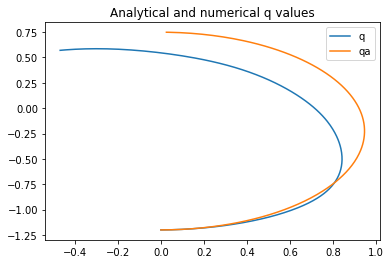

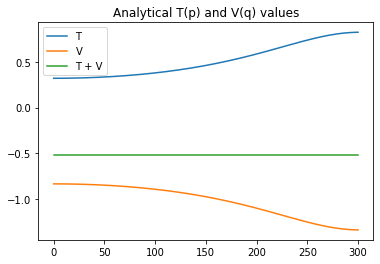

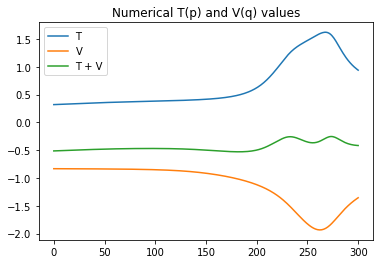

In [246]:
model_two_body()

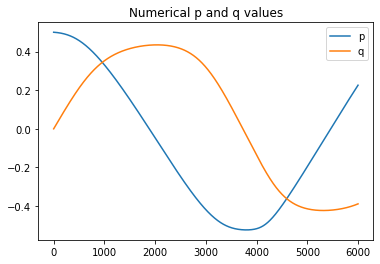

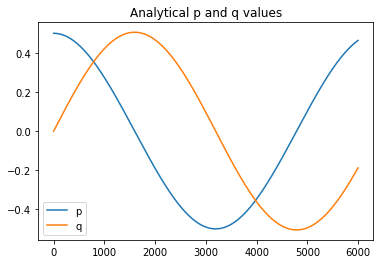

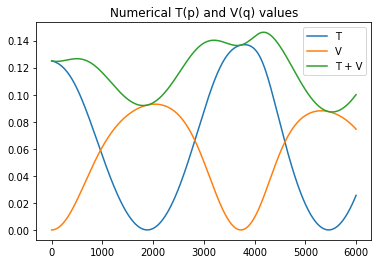

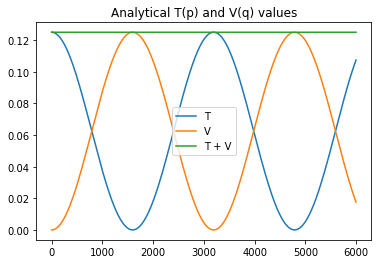

In [247]:
model_nlp()

## 5. c) 
### Then try it on the given data with unknown Hamiltonian References

In [255]:
def model_unknown(low = 0, high = 49):   
    
    K = 20
    h = 0.1
    
    invp_file = open("p_unknown_inv.pkl", "rb")
    invp = pickle.load(invp_file)
    invp_file.close()
    
    invq_file = open("q_unknown_inv.pkl", "rb")
    invq = pickle.load(invq_file)
    invq_file.close()
    
    wp_file = open("p_unknown_w.pkl", "rb")
    thp = pickle.load(wp_file)
    wp_file.close()

    wq_file = open("q_unknown_w.pkl", "rb")
    thq = pickle.load(wq_file)
    wq_file.close()
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 49
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    N = Y.shape[1]
    
    b_indexes = np.arange(low,high+1)
    #for i in range(antB):
    for i in b_indexes:
        print("Batch: " + str(i))
        testbatch = batches[i]
    
    
    
        pa = testbatch["Y_p"]
        Ta = testbatch["c_p"]
        qa = testbatch["Y_q"]
        Va = testbatch["c_q"]
        
        plt.title("Given values for T(p) and V(q)")
        plt.plot(np.reshape(Ta,len(Ta)), label="Ta")
        plt.plot(np.reshape(Va,len(Va)),  label ="Va")
        plt.plot(Ta+Va, label ="Ta + Va")
        plt.legend()
        plt.show()
        
        
        z, yhatp = F_tilde(pa, thp, d_0, d, K, h)
        Tpa = invscaleparameter(yhatp, invp[0], invp[1], invp[2], invp[3])
        z, yhatq = F_tilde(qa, thq, d_0, d, K, h)
        Vqa = invscaleparameter(yhatq, invq[0], invq[1], invq[2], invq[3])
        
        plt.plot(np.reshape(Tpa,len(Tpa)), label="Tpa")
        plt.plot(np.reshape(Vqa,len(Vqa)),  label ="Vqa")
        plt.plot(Tpa+Vqa, label ="Tpa + Vqa")
        plt.legend()
        plt.show()
        
        
        dt = testbatch["t"][1]
        T = dt*N
        p0 = pa[:,0,np.newaxis]
        q0 = qa[:,0,np.newaxis]
        p,q = stormer_verlet(p0, q0, thp, thq, h, K, N, T, invp, invq)
        
        z, yhatpn = F_tilde(p.T, thp, d_0, d, K, h)
        Tp = invscaleparameter(yhatpn, invp[0], invp[1], invp[2], invp[3])
        z, yhatqn = F_tilde(q.T, thq, d_0, d, K, h)
        Vq = invscaleparameter(yhatqn, invq[0], invq[1], invq[2], invq[3])
        
        plt.plot(np.reshape(Tp,len(Tp)), label="Tp")
        plt.plot(np.reshape(Vq,len(Vq)),  label ="Vq")
        plt.plot(Tp+Vq, label ="Tp + Vq")
        plt.legend()
        plt.show()

Batch: 0


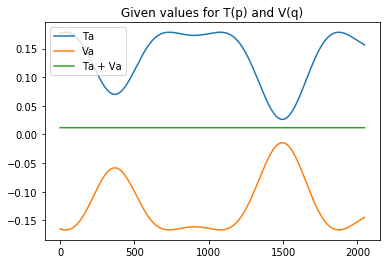

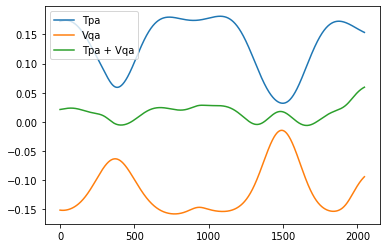

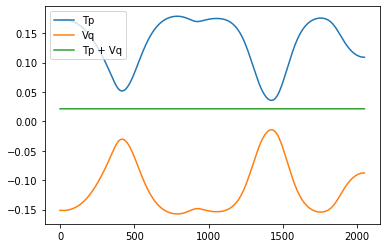

Batch: 1


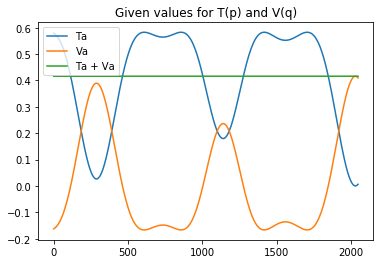

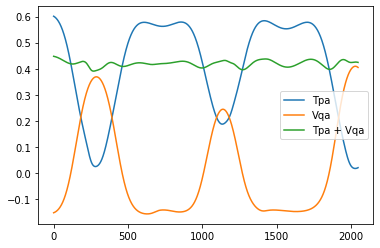

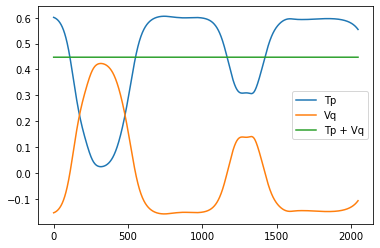

Batch: 2


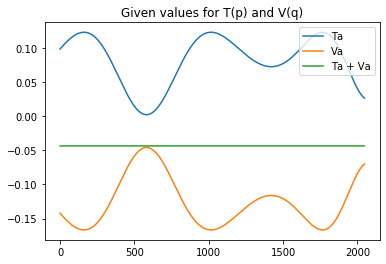

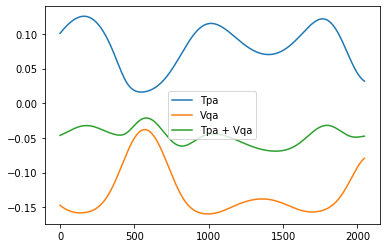

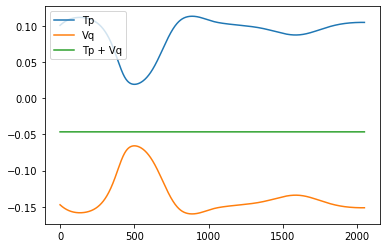

In [256]:
model_unknown(0, 2)

# Table of contents

## 1.

Implement functions for generating synthetic input data.

## 2.
Implement the neural network for training approximation of Hamiltonian function.

## 2. a)
Test the model by using the suggested functions


## 2. b)
Investigate systematically what are optimal choices for K, τ, d, h and any
other choices you need to make. Balance performance in the generalisation
phase with time consumption of training.

## 2. c)
Train the model for the case of data given (with unknown Hamiltonian function)

## 2. d)
Try other alternatives for optimisation, such a the Adam method

## 2. e)
Make use of convergence plots for getting an indication of the efficiency of
your choices.

##  2. g/f) 
Make use of convergence plots for getting an indication of the efficiency of
your choices.

Do a similar evaluation on test data (that were not used in the training phase).


## 3. 
Derive the formulas for computing the gradient of the trained function ($\nabla _y F(y)$)

## 4.
Implement these formulas for computing the gradient

## 5. 
Implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian function

## 5. a) 
Try in particular to test it on the given Hamiltonians

## 5. b) 
HamiltonianTest to which extent the numerical solution preserves the Hamiltonian alongtent the numerical solution preserves the Hamiltonian along
## 5. c)

